In [207]:
import scipy.io as sio
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import numpy as np
import copy

import sys
sys.path.append("../")
import data_helpers

In [ ]:
tires = ["r25b_16x7-5_10x8","r25b_16x7-5_10x7","r25b_16x7-5_10x7","r25b_18x6_10x6","r25b_16x6_10x7","r25b_18x7-5_10x8","r25b_18x7-5_10x7",
        "LCO_16x7-5_10x8","LCO_16x7-5_10x7","LCO_16x7-5_10x7","LCO_18x6_10x6","LCO_16x6_10x7","LCO_18x7-5_10x8","LCO_18x7-5_10x7"]

tire_coeffs = {tire:{"lateral_mus":[], "long_mus":[]} for tire in tires}

camber = 0 # default camber
pressure = 12* 6.89476 # default pressure
velocity = 25 * 1.60934 # default velocity
SA_cutoff = 8 # degrees, where slip occurs
SR_cutoff = 0.1 # %, where slip occurs

load_lateral = np.array([-250, -200, -150, -50]) / 0.224809
load_long = np.array([-250, -200, -150, -50]) / 0.224809

In [208]:
df = data_helpers.import_data(sio.loadmat("../tire_data/processed_data/braking_2021_rears.mat"))


In [209]:
variable_sweeps = {"load" : {"sweep" : np.array([-250, -200, -150, -50]) / 0.224809, "label" : "FZ" },
            "camber" : {"sweep" : np.array([0, 2, 4]), "label" : "IA"},
            "pressure" : {"sweep" : np.array([8, 10, 12, 14]) * 6.89476, "label" : "P"},
            "velocity" : {"sweep" : np.array([25]) * 1.60934, "label" : "V"},
            "slip" : {"sweep" : np.array([0, -3, -6]), "label" : "SA"}}

C:\Users\Kieran\AppData\Local\Programs\Python\Python37\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\Kieran\AppData\Local\Programs\Python\Python37\lib\site-packages\matplotlib\axes\_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
C:\Users\Kieran\AppData\Local\Programs\Python\Python37\lib\site-packages\matplotlib\axes\_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
C:\Users\Kieran\AppData\Local\Programs\Python\Python37\lib\site-packages\matplotl

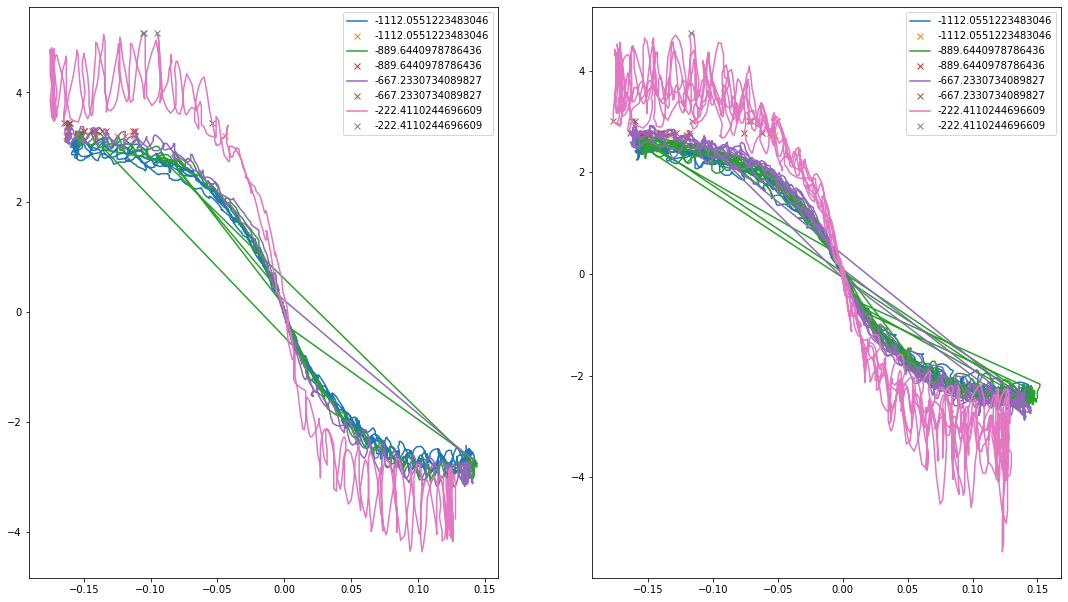

In [210]:
initial_tire = 38 # run ID number
post_tire = 39 # run ID number
slip_angle = 0 # pure long loading
pressure = 12*6.89476 # default pressure
camber = 0 # default camber

initial_df = df[((df["slip"] == slip_angle) & (df["pressure"] == pressure) & (df["camber"] == camber) & (df["RUN"] == initial_tire))]
post_df = df[((df["slip"] == slip_angle) & (df["pressure"] == pressure) & (df["camber"] == camber) & (df["RUN"] == post_tire))]

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18.5, 10.5)
#ax2.plot(post_df["SL"], post_df["NFX"], 'y')
initial_max_data, post_max_data = pd.DataFrame(), pd.DataFrame()

# go through each normal load in discrete sweep
for x in variable_sweeps["load"]["sweep"]:
    load_df = initial_df[initial_df["load"] == x]
    load_df_2 = post_df[post_df["load"] == x]
    ax1.plot(load_df["SL"], load_df["NFX"], label = x)
    ax2.plot(load_df_2["SL"], load_df_2["NFX"], label = x)


    max_mu = initial_df[initial_df["load"] == x]["NFX"].max()
    max_data = initial_df[initial_df["NFX"] == max_mu]
    initial_max_data = pd.concat((initial_max_data, max_data))
    ax1.plot(max_data["SL"], max_data["NFX"], 'x', label = x)
    #print("Force: ", x, max_data["NFX"]*2/3,max_data["SL"],"\n")

    max_mu = post_df[post_df["load"] == x]["NFX"].max()
    max_data = post_df[post_df["NFX"] == max_mu]
    post_max_data = pd.concat((post_max_data, max_data))
    ax2.plot(max_data["SL"], max_data["NFX"], 'x', label = x)
    #print("Force: ", x, max_data["NFX"]*2/3,max_data["SL"],"\n")


        # # TESTING
        # max_mu = initial_df[initial_df["load"] == x]["FX"].max()
        # max_data = initial_df[initial_df["FX"] == max_mu]
        # ax1.plot(max_data["SL"], max_data["NFX"], 'x')
ax1.legend()
ax2.legend()


Average reduction after usage 0.14861275223606943%
Pre Quadratic term: 0.0007157535398411377
Pre Linear term: 2.3507888198757767
Post Quadratic term: 0.0007506581979618819
Post Linear term: 2.0990545905707196


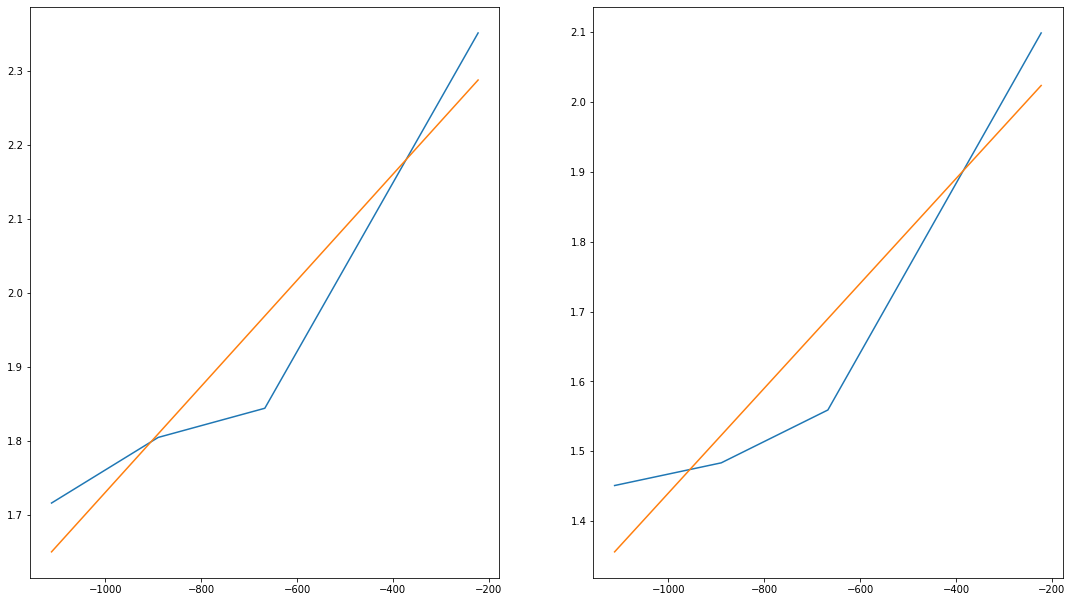

In [211]:
def get_normal_mus(df, normal_loads, lower, metric = "SL", output = "NFX"):
    return_mus = []
    for x in normal_loads:
        load_df = df[(df["load"] == x) & ((df[metric] < -1*lower) | (df[metric] > lower))]
        return_mus.append(load_df[output].abs().mean()*0.6)
    return return_mus

loads = variable_sweeps["load"]["sweep"]
initial_mus = get_normal_mus(initial_df, loads, 0.10)
post_mus = get_normal_mus(post_df, loads, 0.10)

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18.5, 10.5)

reduc = [1 - post_mus[i]/initial_mus[i] for i in range(len(loads))]
print("Average reduction after usage {0}%".format(sum(reduc)/len(reduc)))
ax1.plot(loads, initial_mus)
ax2.plot(loads, post_mus)
func = np.polyfit(loads, initial_mus, 1)

ax1.plot(loads, func[1] + func[0] * loads)
print("Pre Quadratic term:", func[0])
print("Pre Linear term:", initial_mus[len(initial_mus)-1])


func = np.polyfit(loads, post_mus, 1)
ax2.plot(loads, func[1] + func[0] * loads)
print("Post Quadratic term:", func[0])
print("Post Linear term:", post_mus[len(post_mus)-1])

# # go through each normal load in discrete sweep
# for x in variable_sweeps["load"]["sweep"]:
#     load_df = initial_df[initial_df["load"] == x]

[-1.94833711e-04  1.25655606e+00]
Quadratic term: -0.00019483371069505223
Linear term: 1.2688514150943395


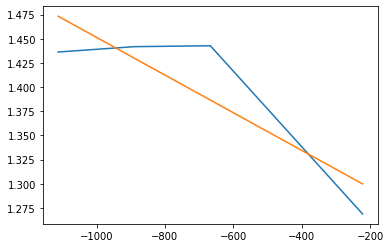

In [212]:
df2 = data_helpers.import_data(sio.loadmat("../tire_data/processed_data/braking_hoosier_r25b_18x6_10x7.mat"))

initial_tire = 43 # run ID number
slip_angle = 0 # pure long loading
pressure = 12*6.89476 # default pressure
camber = 0 # default camber

initial_df = df2[((df2["slip"] == slip_angle) & (df2["pressure"] == pressure) & (df2["camber"] == camber) & (df2["RUN"] == initial_tire))]

loads = variable_sweeps["load"]["sweep"]
initial_mus = get_normal_mus(initial_df, loads, 0.10)

plt.plot(loads, initial_mus)
func = np.polyfit(loads, initial_mus, 1)
print(func)

plt.plot(loads, func[1] + func[0] * loads)
print("Quadratic term:", func[0])
print("Linear term:", initial_mus[len(initial_mus)-1])

[-2.13280114e-04  1.21509437e+00]
Quadratic term: -0.00021328011420273545
Linear term: 1.2326838565022422


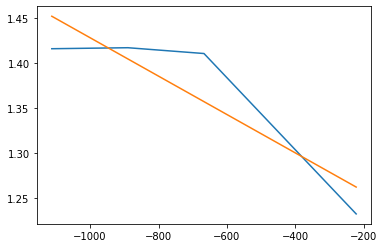

In [213]:
df2 = data_helpers.import_data(sio.loadmat("../tire_data/processed_data/braking_hoosier_r25b_18x6_10x6.mat"))

initial_tire = 41 # run ID number
slip_angle = 0 # pure long loading
pressure = 12*6.89476 # default pressure
camber = 0 # default camber

initial_df = df2[((df2["slip"] == slip_angle) & (df2["pressure"] == pressure) & (df2["camber"] == camber) & (df2["RUN"] == initial_tire))]

loads = variable_sweeps["load"]["sweep"]
initial_mus = get_normal_mus(initial_df, loads, 0.10)

plt.plot(loads, initial_mus)
func = np.polyfit(loads, initial_mus, 1)
print(func)

plt.plot(loads, func[1] + func[0] * loads)
print("Quadratic term:", func[0])
print("Linear term:", initial_mus[len(initial_mus)-1])

C:\Users\Kieran\AppData\Local\Programs\Python\Python37\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\Kieran\AppData\Local\Programs\Python\Python37\lib\site-packages\matplotlib\axes\_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
C:\Users\Kieran\AppData\Local\Programs\Python\Python37\lib\site-packages\matplotlib\axes\_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
C:\Users\Kieran\AppData\Local\Programs\Python\Python37\lib\site-packages\matplotl

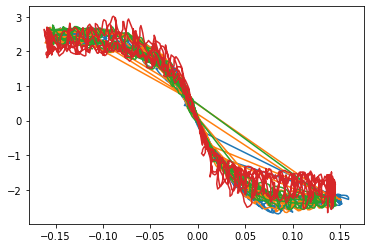

In [214]:
# go through each normal load in discrete sweep
for x in variable_sweeps["load"]["sweep"]:
    load_df = initial_df[initial_df["load"] == x]
    load_df_2 = post_df[post_df["load"] == x]
    plt.plot(load_df["SL"], load_df["NFX"], label = x)

Average reduction after usage 0.08468870322241502%
Pre Quadratic term: 0.0002899498917157756
Pre Linear term: 1.8817561983471074
Post Quadratic term: 0.00035887005094045504
Post Linear term: 1.761297520661157


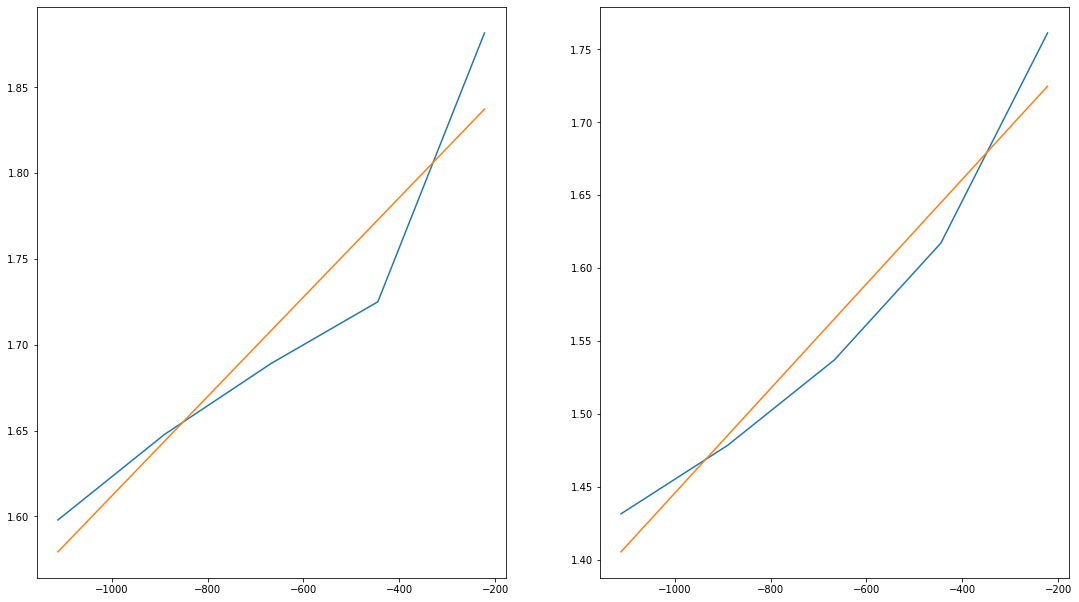

In [216]:
df3 = data_helpers.import_data(sio.loadmat("../tire_data/processed_data/cornering_2021_rears.mat"))

loads_lat = np.array([-250, -200, -150, -100, -50]) / 0.224809

initial_tire = 21 # run ID number
post_tire = 22  # run ID number
pressure = 12*6.89476 # default pressure
camber = 0 # default camber
velocity = 25* 1.60934 # default velocity
slip_angle = 8

initial_df = df3[((df3["velocity"] == velocity) & (df3["pressure"] == pressure) & (df3["camber"] == camber) & (df3["RUN"] == initial_tire))]
post_df = df3[((df3["velocity"] == velocity) & (df3["pressure"] == pressure) & (df3["camber"] == camber) & (df3["RUN"] == post_tire))]

# go through each normal load in discrete sweep
# for x in loads_lat:
#     load_df = initial_df[initial_df["load"] == x]
#     plt.plot(load_df["SA"], load_df["NFY"], label = x)

initial_mus = get_normal_mus(initial_df, loads_lat, slip_angle, "SA", "NFY")
post_mus = get_normal_mus(post_df, loads_lat, slip_angle, "SA", "NFY")

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18.5, 10.5)

reduc = [1 - post_mus[i]/initial_mus[i] for i in range(len(loads_lat))]
print("Average reduction after usage {0}%".format(sum(reduc)/len(reduc)))
ax1.plot(loads_lat, initial_mus)
ax2.plot(loads_lat, post_mus)
func = np.polyfit(loads_lat, initial_mus, 1)

ax1.plot(loads_lat, func[1] + func[0] * loads_lat)
print("Pre Quadratic term:", func[0])
print("Pre Linear term:", initial_mus[len(initial_mus)-1])


func = np.polyfit(loads_lat, post_mus, 1)
ax2.plot(loads_lat, func[1] + func[0] * loads_lat)
print("Post Quadratic term:", func[0])
print("Post Linear term:", post_mus[len(post_mus)-1])

Average reduction after usage 0.054424365175723%
Pre Quadratic term: 0.00026214596128724656
Pre Linear term: 1.684221118881119
Post Quadratic term: 0.0004911892931388649
Post Linear term: 1.7629452995391706


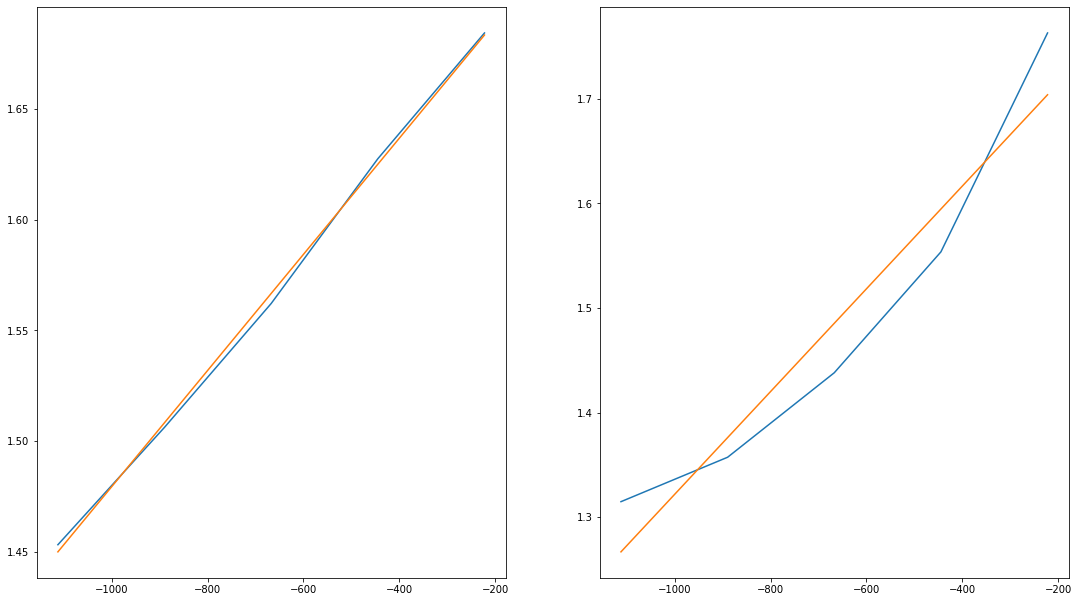

In [219]:
df4 = data_helpers.import_data(sio.loadmat("../tire_data/processed_data/cornering_2021_fronts_10x7.mat"))

loads_lat = np.array([-250, -200, -150, -100, -50]) / 0.224809

initial_tire = 12 # run ID number
post_tire = 13  # run ID number
pressure = 12*6.89476 # default pressure
camber = 0 # default camber
velocity = 25* 1.60934 # default velocity
slip_angle = 8

initial_df = df4[((df4["velocity"] == velocity) & (df4["pressure"] == pressure) & (df4["camber"] == camber) & (df4["RUN"] == initial_tire))]
post_df = df4[((df4["velocity"] == velocity) & (df4["pressure"] == pressure) & (df4["camber"] == camber) & (df4["RUN"] == post_tire))]

# go through each normal load in discrete sweep
# for x in loads_lat:
#     load_df = initial_df[initial_df["load"] == x]
#     plt.plot(load_df["SA"], load_df["NFY"], label = x)

initial_mus = get_normal_mus(initial_df, loads_lat, slip_angle, "SA", "NFY")
post_mus = get_normal_mus(post_df, loads_lat, slip_angle, "SA", "NFY")

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18.5, 10.5)

reduc = [1 - post_mus[i]/initial_mus[i] for i in range(len(loads_lat))]
print("Average reduction after usage {0}%".format(sum(reduc)/len(reduc)))
ax1.plot(loads_lat, initial_mus)
ax2.plot(loads_lat, post_mus)
func = np.polyfit(loads_lat, initial_mus, 1)

ax1.plot(loads_lat, func[1] + func[0] * loads_lat)
print("Pre Quadratic term:", func[0])
print("Pre Linear term:", initial_mus[len(initial_mus)-1])


func = np.polyfit(loads_lat, post_mus, 1)
ax2.plot(loads_lat, func[1] + func[0] * loads_lat)
print("Post Quadratic term:", func[0])
print("Post Linear term:", post_mus[len(post_mus)-1])

Average reduction after usage 0.040192401656996356%
Pre Quadratic term: 0.0003211723605687993
Pre Linear term: 1.7545525714285712
Post Quadratic term: 0.00042248489983131015
Post Linear term: 1.7567015384615385


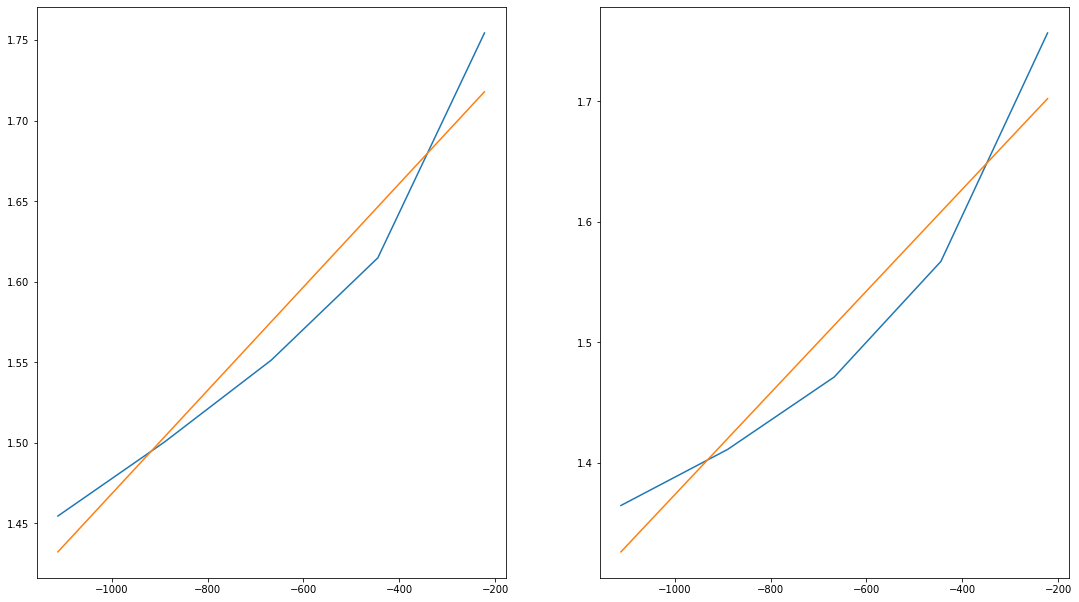

In [224]:
df5 = data_helpers.import_data(sio.loadmat("../tire_data/processed_data/cornering_2021_r25b_16x7-5_10x8.mat"))

loads_lat = np.array([-250, -200, -150, -100, -50]) / 0.224809

initial_tire = 6 # run ID number
post_tire = 7  # run ID number
pressure = 12*6.89476 # default pressure
camber = 0 # default camber
velocity = 25* 1.60934 # default velocity
slip_angle = 8

initial_df = df5[((df5["velocity"] == velocity) & (df5["pressure"] == pressure) & (df5["camber"] == camber) & (df5["RUN"] == initial_tire))]
post_df = df5[((df5["velocity"] == velocity) & (df5["pressure"] == pressure) & (df5["camber"] == camber) & (df5["RUN"] == post_tire))]

# go through each normal load in discrete sweep
# for x in loads_lat:
#     load_df = initial_df[initial_df["load"] == x]
#     plt.plot(load_df["SA"], load_df["NFY"], label = x)

initial_mus = get_normal_mus(initial_df, loads_lat, slip_angle, "SA", "NFY")
post_mus = get_normal_mus(post_df, loads_lat, slip_angle, "SA", "NFY")

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18.5, 10.5)

reduc = [1 - post_mus[i]/initial_mus[i] for i in range(len(loads_lat))]
print("Average reduction after usage {0}%".format(sum(reduc)/len(reduc)))
ax1.plot(loads_lat, initial_mus)
ax2.plot(loads_lat, post_mus)
func = np.polyfit(loads_lat, initial_mus, 1)

ax1.plot(loads_lat, func[1] + func[0] * loads_lat)
print("Pre Quadratic term:", func[0])
print("Pre Linear term:", initial_mus[len(initial_mus)-1])


func = np.polyfit(loads_lat, post_mus, 1)
ax2.plot(loads_lat, func[1] + func[0] * loads_lat)
print("Post Quadratic term:", func[0])
print("Post Linear term:", post_mus[len(post_mus)-1])

In [ ]:
plt